**Let's prepare the data:**

In [71]:
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr 
from scipy.stats import linregress
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score,normalized_mutual_info_score
from pingouin import distance_corr,linear_regression
from math import ceil, floor
from scipy.signal import get_window

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from hurst import compute_Hc
import hfda
sns.set(rc={'figure.figsize': (15, 8)})

In [2]:
inflation= pd.read_csv('data/inflation.csv', sep = ",")
price_index = pd.read_csv('data/Price_index.csv', sep = ",")
monetary_base= pd.read_csv('data/monetary_base.csv', sep = ",", thousands='.')

In [3]:
monetary_base['Dates'] = pd.to_datetime(monetary_base['Dates'], format = '%d/%m/%Y')    
monetary_base.index = monetary_base['Dates']
monetary_base = monetary_base.drop(['Dates'], axis = 1)

In [4]:
price_index['Mes'] = pd.to_datetime(price_index['Mes'], format = '%b-%y')
price_index = price_index.rename(columns = {'Mes' : 'Dates'})
price_index = price_index.replace({'%':''}, regex=True)
price_index.index = price_index['Dates']
price_index['% de var. mensual'] = price_index['% de var. mensual'].astype(float)
price_index = price_index.drop(['% de var. anual', 'Nivel', 'Dates'], axis = 1)
price_index = price_index.resample('1M').mean().dropna()
price_index = price_index.rename(columns = {'% de var. mensual' : 'Inflation'})

In [5]:
# Old Inflation Data
inflation['Dates'] = pd.to_datetime(inflation['Dates'], format = '%d/%m/%Y')    
inflation.index = inflation['Dates']
inflation = inflation.drop(['Dates'], axis = 1)

Replacing inflation values between 2007 and 2015

In [6]:
start, end = pd.to_datetime('2007-01-31'), pd.to_datetime('2015-12-31')
inflation.loc[start : end, 'Inflation'] = price_index.loc[start : end, 'Inflation']

Monetary Base with LELIQ and LEBAC

In [375]:
monetary_base_leliq_lebac = pd.read_csv('data/mb_leliq_lebac.csv', sep = ",", thousands = ',')
monetary_base_leliq_lebac['Fecha'] = pd.to_datetime(monetary_base_leliq_lebac['Fecha'], format = '%d-%b-%y')
monetary_base_leliq_lebac = monetary_base_leliq_lebac.rename(columns = {'Fecha' : 'Dates'})
monetary_base_leliq_lebac.index = monetary_base_leliq_lebac['Dates']
monetary_base_leliq_lebac = monetary_base_leliq_lebac.drop(['Dates'], axis = 1)

In [376]:
monetary_base_leliq_lebac['Saldo diario total'] = monetary_base_leliq_lebac['Saldo diario total'].astype('int32')
monetary_base_leliq_lebac['LELIQ'] = monetary_base_leliq_lebac['LELIQ'].astype('int32')
monetary_base_leliq_lebac['LEBAC y NOBAC'] = monetary_base_leliq_lebac['LEBAC y NOBAC'].astype('int32')
monetary_base_leliq_lebac['Monetary Base'] = monetary_base_leliq_lebac['Saldo diario total'] 


In [377]:
for column in monetary_base_leliq_lebac.columns:
    columns_to_keep = ['LELIQ', 'LEBAC y NOBAC', 'Monetary Base']
    if column not in columns_to_keep:
        monetary_base_leliq_lebac = monetary_base_leliq_lebac.drop(column, axis = 1)

In [378]:
monetary_base_leliq_lebac['cumulative LELIQ + LEBAC'] = monetary_base_leliq_lebac['LEBAC y NOBAC'].cumsum() + monetary_base_leliq_lebac['LELIQ'].cumsum()

In [379]:
monetary_base_leliq_lebac['Monetary Base'] -= monetary_base_leliq_lebac['cumulative LELIQ + LEBAC']

Replacing data from 2003

In [380]:
start, end = pd.to_datetime('2003-01-02'), pd.to_datetime('2019-12-31')
monetary_base.loc[start : end, 'Monetary Base'] = monetary_base_leliq_lebac.loc[start : end, 'Monetary Base']

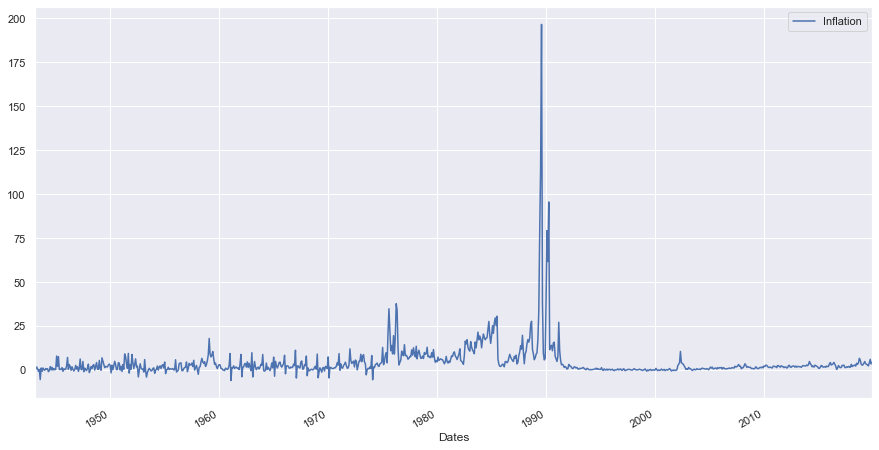

In [381]:
ax = inflation.plot()


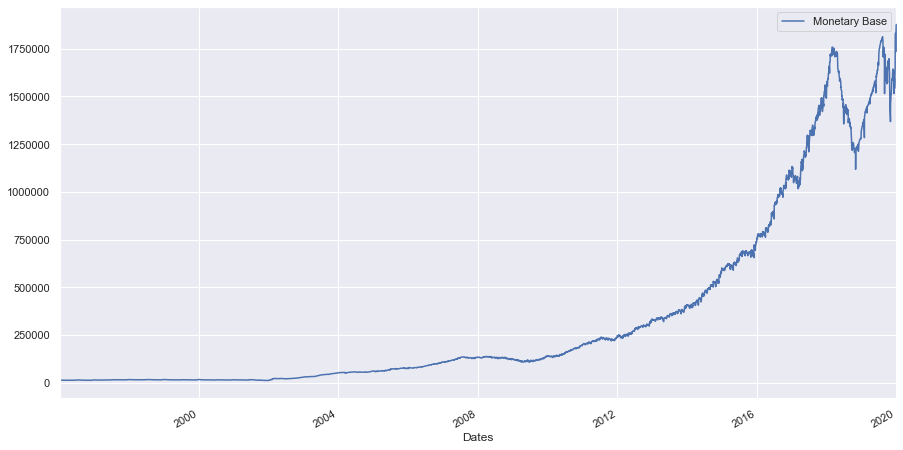

In [382]:
ax = monetary_base.plot()
#ax.set(yscale="log")

In [383]:
inflation_1996 = {}
monetary_base_change_1996 = {}
data_1996 = {}
months = [1, 3, 6, 12]
for m in months:
    inflation_1996[m] = inflation.truncate(before = '1996-01-01')
    #inflation_1996[m] = price_index.truncate(before = '1997-01-01')
    #inflation_1996[m] = inflation_1996[m].rename(columns = {'% de var. mensual' : 'Inflation'})
    inflation_1996[m] = inflation_1996[m].apply(lambda x : x/100+1)
    inflation_1996[m] = inflation_1996[m].resample(str(m) + 'M').apply(lambda x : x.cumprod()[-1])
    inflation_1996[m] = inflation_1996[m].apply(lambda x : (x - 1) * 100)
    monetary_base_change_1996[m] = monetary_base.truncate(before = '1996-01-01')
    monetary_base_change_1996[m] = monetary_base_change_1996[m].resample(str(m) + 'M').mean().pct_change()*100
    data_1996[m] = pd.DataFrame(monetary_base_change_1996[m])
    data_1996[m] = data_1996[m].assign(Inflation = inflation_1996[m]['Inflation']).dropna()

**Now let's calculate the pearson correlation:**

In [384]:
pearson_lagged = {}
for m in months:
    max_lag = 12*4//m
    correlation=[]
    for lag in np.arange(0, max_lag + 1, 1):
        correlation.append(data_1996[m]['Inflation'].corr(data_1996[m]['Monetary Base'].shift(lag)))
    pearson_lagged[m]=correlation

In [385]:
to_plot = pd.DataFrame()
for m in months:
    to_plot=to_plot.append(pd.DataFrame([np.linspace(0,4,len(pearson_lagged[m])),pearson_lagged[m],[str(m)+ 'm']*len(pearson_lagged[m])]).T)
to_plot=to_plot.rename(columns={2:'months'})

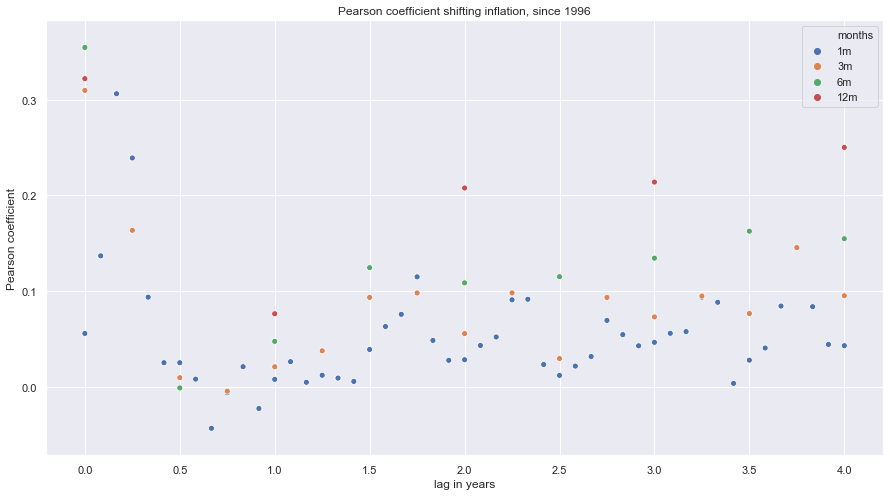

In [386]:
ax = sns.scatterplot(x= to_plot[0], y = to_plot[1], data = to_plot, hue = 'months')
ax.set(xlabel = 'lag in years', ylabel = 'Pearson coefficient', title = 'Pearson coefficient shifting inflation, since 1996')
ax

In [387]:
to_plot_heatmap = pd.DataFrame()
b=[]
for m in months:
    a=[ceil(m / 2)]+[m]*(48 // m-1) + [ceil(m / 2) + (m + 1)%2]
    to_plot_heatmap = to_plot_heatmap.append(pd.DataFrame([np.linspace(0, 4, 49), np.repeat(pearson_lagged[m], a),[m]*49]).T)
    b.append(np.repeat(pearson_lagged[m], a))
to_plot_heatmap = to_plot_heatmap.rename(columns = {0 : 'Lag in years', 2 : 'Months averaged'})

In [388]:
b=np.array(b)

[]

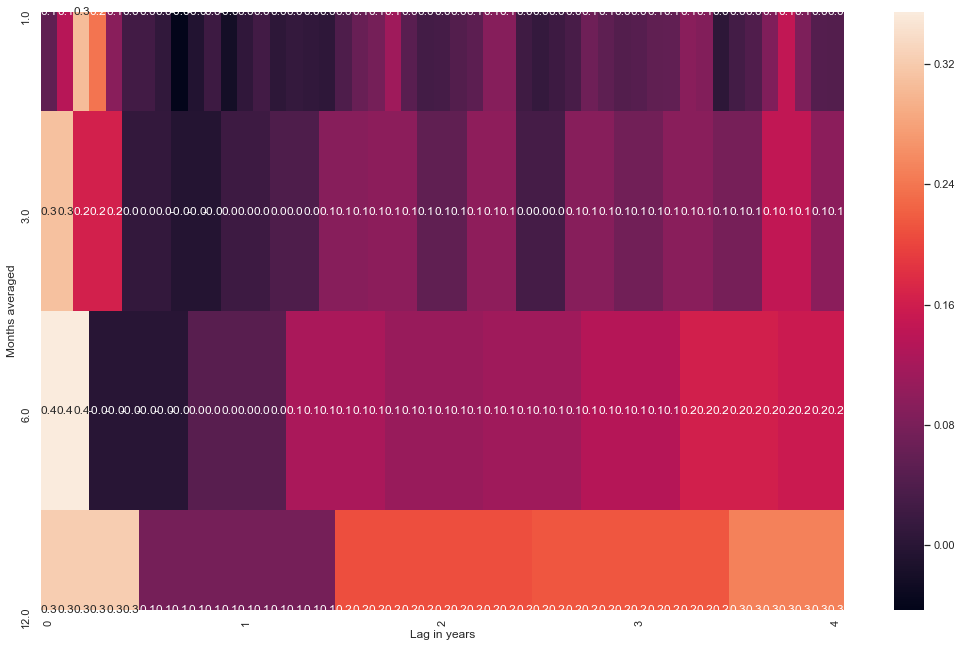

In [389]:
plt.figure(figsize=(18,11))

figure = to_plot_heatmap.pivot("Months averaged", 'Lag in years', 1)
sns.heatmap(figure,annot = b, fmt='.1f')
plt.xticks(np.arange(49) + 0.5, ['0'] + [None]*11 + ['1']+ [None]*11 + ['2'] + [None]*11 + ['3'] + [None]*11 + ['4'])
plt.plot()

Scatterplot x=Change in Monetary Base and y= Inflation rate

Text(0.5, 0, 'Change MB')

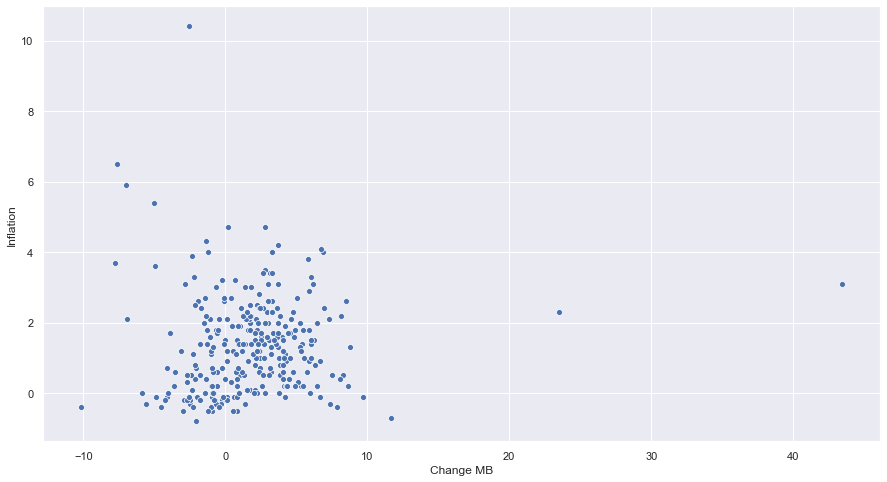

In [390]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'], y = data_1996[1]['Inflation'])
ax.set_xlabel('Change MB')

**Scatterplot x=Change in Monetary Base shifted 12 months and y= Inflation**

Text(0.5, 0, 'Change MB')

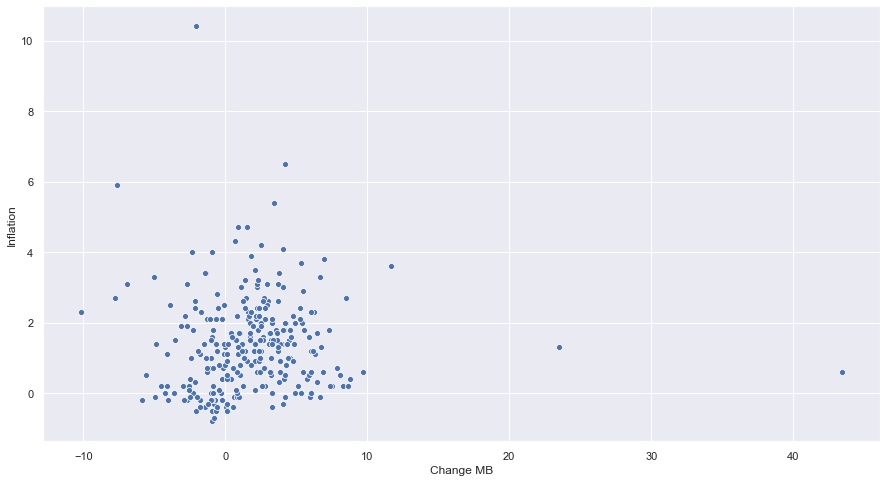

In [391]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(12)[12:], y = data_1996[1]['Inflation'][12:])
ax.set_xlabel('Change MB')

**Scatterplot x=Change in Monetary Base shifted 24 months and y= Inflation**

Text(0.5, 0, 'Change MB')

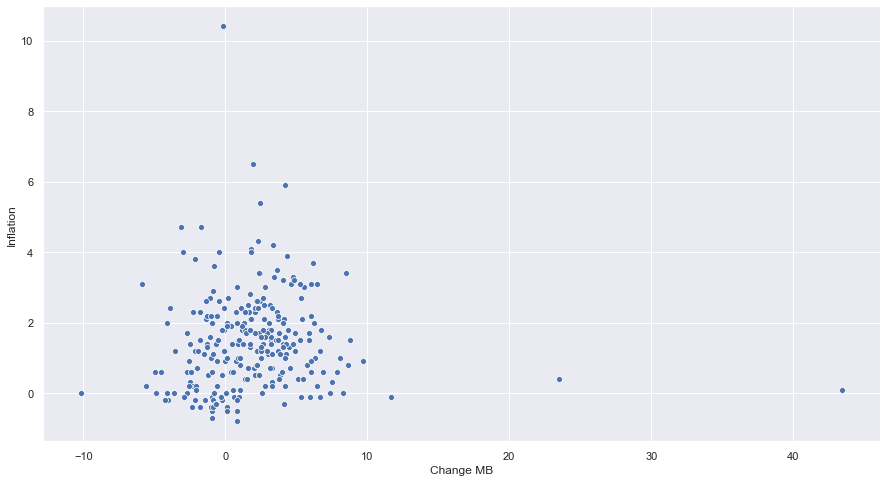

In [393]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(24)[24:], y = data_1996[1]['Inflation'][24:])
ax.set_xlabel('Change MB')

**Scatterplot x=Change in Monetary Base shifted 36 months and y= Inflation**

Text(0.5, 0, 'Change MB')

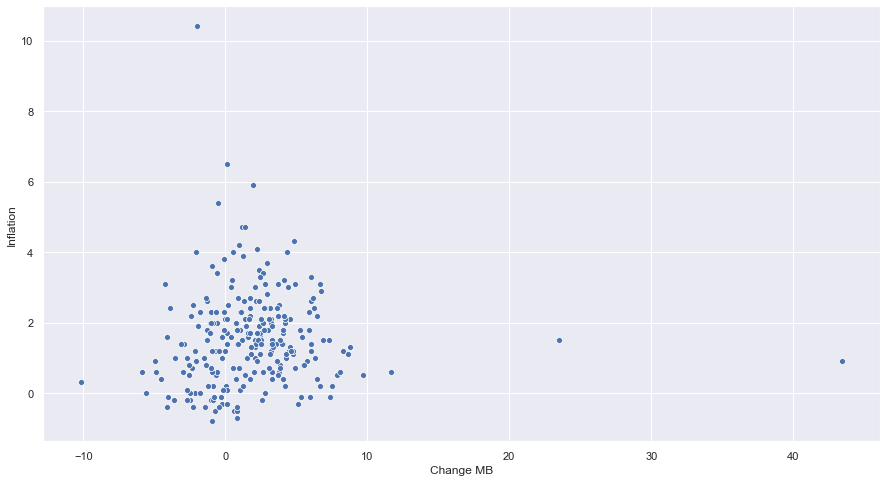

In [394]:
ax = sns.scatterplot(x = data_1996[1]['Monetary Base'].shift(36)[36:], y = data_1996[1]['Inflation'][36:])
ax.set_xlabel('Change MB')

**Hurst Exponent calculation**


In [395]:
H_Change_MB, c, data = compute_Hc(data_1996[1]['Monetary Base'].values, kind='change', simplified=True)
H_Change_MB

0.7176864821352322

In [396]:
H_Inflation, c, data = compute_Hc(data_1996[1]['Inflation'].values, kind='change', simplified=True)
H_Inflation

0.6928803033730169

H index calculated with kind= 'price' (a series is a cumulative product of changes)

In [397]:
Cumulative_Inflation = inflation_1996[1].truncate(before = '1997-01-01')
Cumulative_Inflation = Cumulative_Inflation.apply(lambda x : x/100+1)
Cumulative_Inflation = Cumulative_Inflation.resample(str(1) + 'M').apply(lambda x : x.cumprod()[-1]).dropna()

In [398]:
H_Inflation, c, data = compute_Hc(Cumulative_Inflation, kind='price', simplified=True)
H_Inflation

0.5148346497551712

Change in MB has a **persistent behavior**, but Inflation does not have persistence 

**calculating H index with a rolling window**

In [399]:
roll_months = 100
roll_Change_MB = data_1996[1]['Monetary Base'].rolling(roll_months, center = False)
roll_inflation = data_1996[1]['Inflation'].rolling(roll_months, center = False)

In [400]:
window = np.arange(0,101,1)
window = window/sum(window) 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


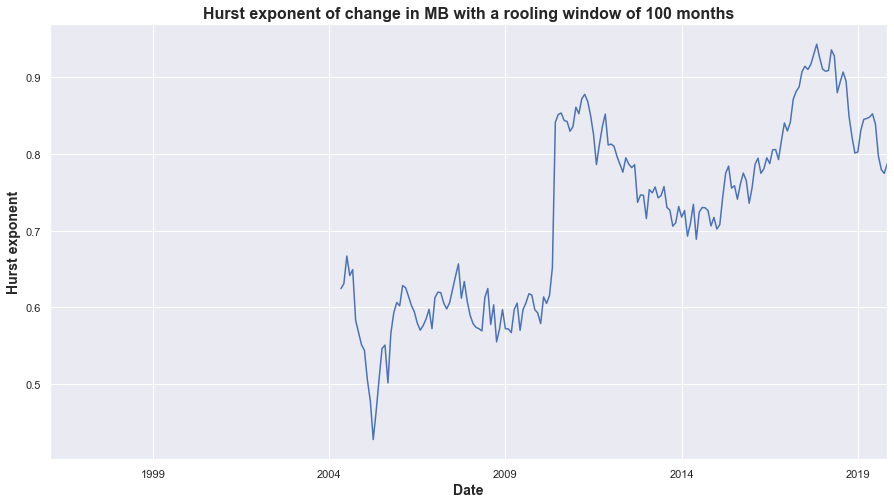

In [401]:
ax = roll_Change_MB.apply(lambda x : compute_Hc(x, kind = 'change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of change in MB with a rooling window of 100 months', weight='bold', fontsize = 16)
ax.set_ylabel('Hurst exponent', weight='bold', fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)
ax

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


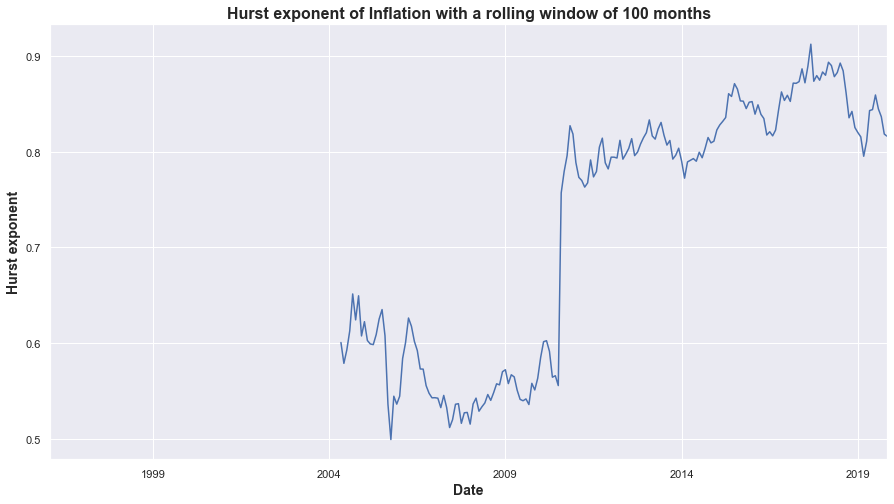

In [402]:
ax = roll_inflation.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0]).plot()
ax.set_title('Hurst exponent of Inflation with a rolling window of 100 months', weight = 'bold', fontsize = 16)
ax.set_ylabel('Hurst exponent', weight = 'bold',fontsize = 14)
ax.set_xlabel('Date', weight = 'bold', fontsize = 14)
ax

In [403]:
v=roll_inflation.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


The behavior of the inflation seems more complicated than change in MB

**Calculation of fractal dimension using Higuchi Fractal Dimension Analysis**


*k_max* is the number of series taken to calculate the index

In [119]:
D_Change_MB = []
for k_max in np.arange(5, 20, 5):
    D_Change_MB.append(roll_Change_MB.apply(lambda x : hfda.measure(np.convolve(x,window), k_max)))


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


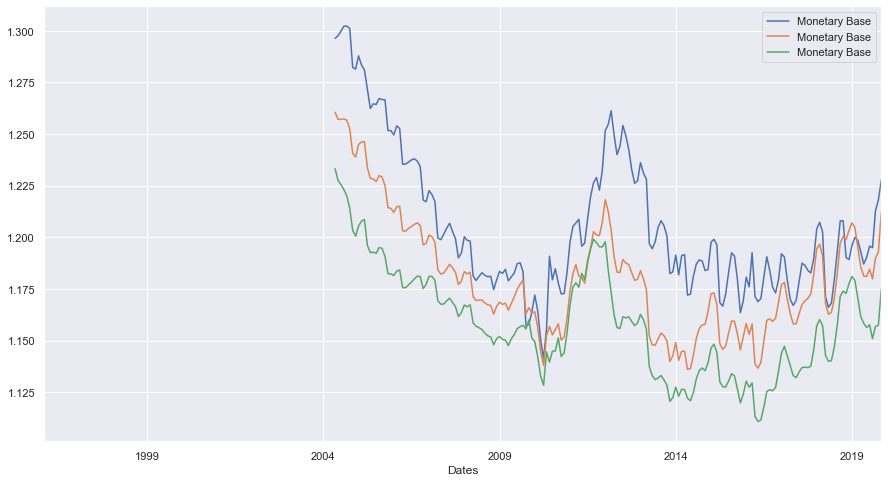

In [120]:
D_index = pd.DataFrame(D_Change_MB).T
D_index.plot()

In [404]:
D_index.columns

Index(['Inflation', 'Inflation', 'Inflation'], dtype='object')

In [405]:
D_Inflation = []
for k_max in np.arange(5, 20, 5):
    D_Inflation.append(roll_inflation.apply(lambda x : hfda.measure(np.convolve(x,window), k_max)))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


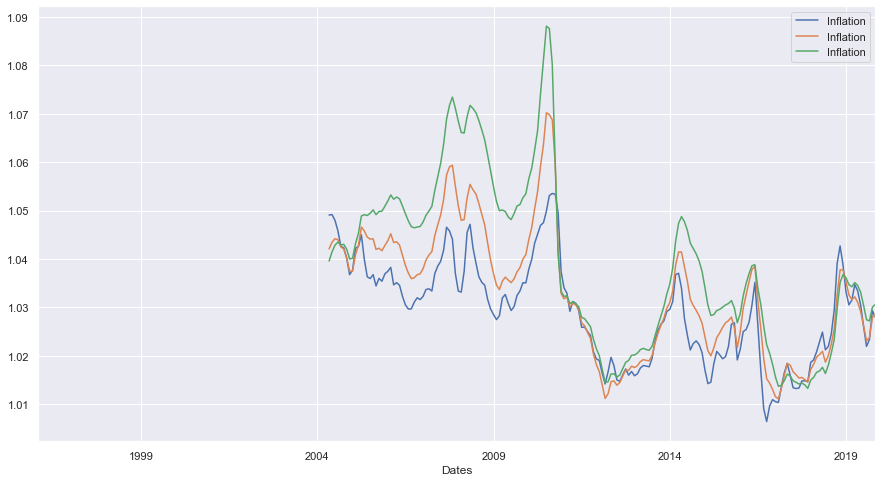

In [406]:
D_index = pd.DataFrame(D_Inflation).T
D_index.plot()

In [58]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result

In [59]:
aut=autocorr(data_1996[1]['Monetary Base'].values)

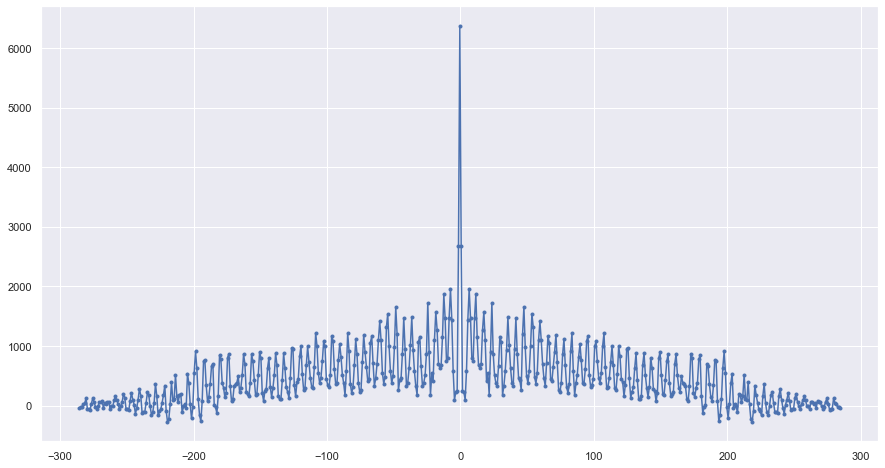

In [60]:
plt.plot(np.arange(-aut.shape[0]/2,aut.shape[0]/2),aut,'-o',markersize=3)

In [62]:
aut=autocorr(data_1996[1]['Inflation'].values)

Text(0.5, 0, 'time [months]')

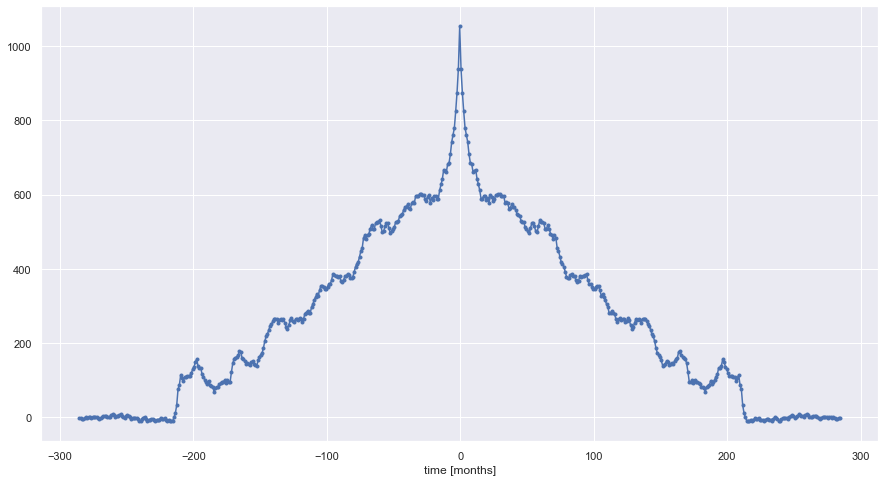

In [63]:
ax=plt.plot(np.arange(-aut.shape[0]/2,aut.shape[0]/2),aut,'-o',markersize=3)
plt.xlabel('time [months]')

In [159]:
v=roll_inflation.apply(lambda x : compute_Hc(x, kind='change', simplified=True)[0]).truncate(before = '2010-04-01')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [161]:
v=pd.DataFrame(v)

In [170]:
v.index-pd.DateOffset(months=100)

DatetimeIndex(['2001-12-30', '2002-01-31', '2002-02-28', '2002-03-31',
               '2002-04-30', '2002-05-30', '2002-06-30', '2002-07-30',
               '2002-08-31', '2002-09-30',
               ...
               '2010-10-28', '2010-11-30', '2010-12-30', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-30',
               '2011-06-30', '2011-07-30'],
              dtype='datetime64[ns]', name='Dates', length=116, freq=None)

In [171]:
v

,Inflation
Dates,
2010-04-30,0.591276
2010-05-31,0.564269
2010-06-30,0.565819
2010-07-31,0.555531
2010-08-31,0.757016
2010-09-30,0.779346
2010-10-31,0.795863
2010-11-30,0.827227
2010-12-31,0.818481
